# ADS 509 Team 1 Project - Tesla vs Toyota News Articles
### By: Jesse Gutierrez, Roger Qiu, Shailja Somani

link: https://newsapi.org/

newsapi key: d6995599193044b0a5f954c098da84d6

## Part 1. API retrival, pre-processing and EDA

### Install and add imports

In [1]:
pip install newsapi-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
from newsapi import NewsApiClient
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import regex as re

import nltk
nltk.download('stopwords')

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/roger.qiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Check the newsAPI data source

In [3]:
# use API key to initialize newsapi client
newsapi = NewsApiClient(api_key='d6995599193044b0a5f954c098da84d6')
newsapi

In [5]:
# check what the top headlines data looks like
top_headlines = newsapi.get_top_headlines(q='world',
                                          category='business',
                                          language='en',
                                          country='us')

top_headlines                                    

{'status': 'ok',
 'totalResults': 2,
 'articles': [{'source': {'id': None, 'name': 'BleepingComputer'},
   'author': 'Sergiu Gatlan',
   'title': 'Rockwell Automation warns admins to take ICS devices offline - BleepingComputer',
   'description': 'Rockwell Automation warned customers to disconnect all industrial control systems (ICSs) not designed for online exposure from the Internet due to increasing malicious activity worldwide.',
   'url': 'https://www.bleepingcomputer.com/news/security/rockwell-automation-warns-admins-to-take-ics-devices-offline/',
   'urlToImage': 'https://www.bleepstatic.com/content/hl-images/2024/05/21/Rockwell.jpg',
   'publishedAt': '2024-05-21T17:48:44Z',
   'content': 'Rockwell Automation warned customers to disconnect all industrial control systems (ICSs) not designed for online exposure from the Internet due to increasing malicious activity worldwide.\r\nNetwork de… [+2415 chars]'},
  {'source': {'id': None, 'name': '8News'},
   'author': 'Addy Bink',
   

In [7]:
# check all the available news sources
sources = newsapi.get_sources()

# check first 3
sources['sources'][:3]

[{'id': 'abc-news',
  'name': 'ABC News',
  'description': 'Your trusted source for breaking news, analysis, exclusive interviews, headlines, and videos at ABCNews.com.',
  'url': 'https://abcnews.go.com',
  'category': 'general',
  'language': 'en',
  'country': 'us'},
 {'id': 'abc-news-au',
  'name': 'ABC News (AU)',
  'description': "Australia's most trusted source of local, national and world news. Comprehensive, independent, in-depth analysis, the latest business, sport, weather and more.",
  'url': 'https://www.abc.net.au/news',
  'category': 'general',
  'language': 'en',
  'country': 'au'},
 {'id': 'aftenposten',
  'name': 'Aftenposten',
  'description': 'Norges ledende nettavis med alltid oppdaterte nyheter innenfor innenriks, utenriks, sport og kultur.',
  'url': 'https://www.aftenposten.no',
  'category': 'general',
  'language': 'no',
  'country': 'no'}]

### Retrieve and download Toyota and Tesla related articles

In [9]:
# get toyota news text data
toyota_raw = newsapi.get_everything(q='toyota',
                                      from_param='2024-04-25',
                                      to='2024-05-25',
                                      language='en',
                                      sort_by='relevancy',
                                      page=5)

toyota_raw['articles'][:3]

[{'source': {'id': None, 'name': 'The Daily Dot'},
  'author': 'Braden Bjella',
  'title': '’24 hours later, the thing broke down’: GM worker forced to get a Silverado after being told she would get fired if she bought Toyota 4Runner',
  'description': 'A user on TikTok is calling out General Motors after claiming the company sold her a “lemon”—which then proceeded to cause issues in her life for months.\n\n\nGeneral Motors vehicles are already not very popular on the TikTok platform. One TikTok user claimed th…',
  'url': 'https://www.dailydot.com/news/gm-worker-forced-to-buy-silverado/',
  'urlToImage': 'https://uploads.dailydot.com/2024/04/general-motors-repo.jpg?auto=compress&fm=pjpg',
  'publishedAt': '2024-04-26T14:00:00Z',
  'content': 'A user on TikTok is calling out General Motors after claiming the company sold her a lemonwhich then proceeded to cause issues in her life for months.\r\nGeneral Motors vehicles are already not very po… [+3148 chars]'},
 {'source': {'id': None, '

In [ ]:
# convert the json into a df
df = pd.DataFrame(toyota_raw['articles'])
df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'The Daily Dot'}",Melody Heald,‘But they want to sell us Nissan’: Nissan work...,Charlotte-based Nissan saleswoman Martina (@ma...,https://www.dailydot.com/news/nissan-workers-d...,https://uploads.dailydot.com/2024/04/nissan-ca...,2024-04-24T14:00:00Z,Charlotte-based Nissan saleswoman Martina (@ma...
1,"{'id': None, 'name': 'The Daily Dot'}",Rachel Kiley,‘Feel sad for Nissan’: Mechanic shares his pic...,Buying a car is a long-term commitment—and an ...,https://www.dailydot.com/news/nissan-money-pit/,https://uploads.dailydot.com/2024/04/nissan-ca...,2024-05-02T04:00:00Z,Buying a car is a long-term commitmentand an i...
2,"{'id': None, 'name': 'Independent.ie'}",Ralph Riegel,‘It's baffling’ – Gardaí appeal for help to so...,Gardaí are to launch a special appeal for info...,https://www.independent.ie/irish-news/its-baff...,https://focus.independent.ie/thumbor/UQaguxNIx...,2024-04-29T01:30:00Z,Gardaí are to launch a special appeal for info...
3,"{'id': None, 'name': 'Bangkok Post'}",Reuters,Car production down 23.1% y/y in March,Car production in Thailand dropped 23.08% in M...,https://www.bangkokpost.com/business/general/2...,https://static.bangkokpost.com/media/content/2...,2024-04-25T04:11:00Z,Car production in Thailand dropped 23.08% in M...
4,"{'id': None, 'name': 'Bangkok Post'}",Online Reporters,"500,000 speed pills found hidden under car","A drug courier was arrested after about 500,00...",https://www.bangkokpost.com/thailand/general/2...,https://static.bangkokpost.com/media/content/2...,2024-04-30T13:14:00Z,"A drug courier was arrested after about 500,00..."


In [ ]:
# create a data folder to store the csv data
if not os.path.exists('data/toyota'):
    os.makedirs('data/toyota')

In [ ]:
# download the toyota text data to data folder
df.to_csv('data/toyota/data.csv', index=False)

In [ ]:
# now do the same for tesla articles and text data
tesla_raw = newsapi.get_everything(q='tesla',
                                      from_param='2024-04-20',
                                      to='2024-05-05',
                                      language='en',
                                      sort_by='relevancy',
                                      page=5)

df = pd.DataFrame(tesla_raw['articles'])

if not os.path.exists('data/tesla'):
    os.makedirs('data/tesla')

df.to_csv('data/tesla/data.csv', index=False)

### read in and intial transformations

In [9]:
# read in the data
raw_tesla = pd.read_csv('data/tesla/data.csv')
raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...


In [12]:
# 100 records with 8 fields
raw_tesla.shape

(100, 8)

In [19]:
# read the CSV file again
raw_toyota = pd.read_csv('data/toyota/data.csv')
raw_toyota.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'The Daily Dot'}",Melody Heald,‘But they want to sell us Nissan’: Nissan work...,Charlotte-based Nissan saleswoman Martina (@ma...,https://www.dailydot.com/news/nissan-workers-d...,https://uploads.dailydot.com/2024/04/nissan-ca...,2024-04-24T14:00:00Z,Charlotte-based Nissan saleswoman Martina (@ma...
1,"{'id': None, 'name': 'The Daily Dot'}",Rachel Kiley,‘Feel sad for Nissan’: Mechanic shares his pic...,Buying a car is a long-term commitment—and an ...,https://www.dailydot.com/news/nissan-money-pit/,https://uploads.dailydot.com/2024/04/nissan-ca...,2024-05-02T04:00:00Z,Buying a car is a long-term commitmentand an i...
2,"{'id': None, 'name': 'Independent.ie'}",Ralph Riegel,‘It's baffling’ – Gardaí appeal for help to so...,Gardaí are to launch a special appeal for info...,https://www.independent.ie/irish-news/its-baff...,https://focus.independent.ie/thumbor/UQaguxNIx...,2024-04-29T01:30:00Z,Gardaí are to launch a special appeal for info...
3,"{'id': None, 'name': 'Bangkok Post'}",Reuters,Car production down 23.1% y/y in March,Car production in Thailand dropped 23.08% in M...,https://www.bangkokpost.com/business/general/2...,https://static.bangkokpost.com/media/content/2...,2024-04-25T04:11:00Z,Car production in Thailand dropped 23.08% in M...
4,"{'id': None, 'name': 'Bangkok Post'}",Online Reporters,"500,000 speed pills found hidden under car","A drug courier was arrested after about 500,00...",https://www.bangkokpost.com/thailand/general/2...,https://static.bangkokpost.com/media/content/2...,2024-04-30T13:14:00Z,"A drug courier was arrested after about 500,00..."


In [20]:
# also 100 records and 8 fields
raw_toyota.shape

(100, 8)

In [24]:
# check how the title looks
raw_tesla['title'][0]

'Tesla “Full Self Driving” Could Come To Other Countries Before Long'

In [25]:
# check how content looks
raw_tesla['content'][0]

'Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]'

In [26]:
# check how the description looks
raw_tesla['description'][0]

# descriptions gives more information than content field.
# so title and description are the 2 fields we can use to combine into a new "text" field.

'Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…'

In [28]:
# label both df's and then union into 1 df with 200 records
raw_tesla['label'] = 'tesla'
raw_toyota['label'] = 'toyota'

raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla


In [60]:
# union
combined = pd.concat([raw_tesla, raw_toyota], axis=0, ignore_index=True)
combined.shape

(200, 9)

In [61]:
# concat title with description to create text field
combined['text'] = combined['title'] + ' ' + combined['description']
combined['text'][0]

'Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…'

In [62]:
# check another example
combined['text'][105]

'Hyundai Motor India reports marginal growth in its April sales; Toyota grows 32%; MG Motor declines Hyundai Motor India achieves fourth consecutive month of 50,000-plus units in domestic sales during calendar year 2024'

In [63]:
# add a length field to check text lengths
combined['length'] = combined['text'].str.len()
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla,More Than 3× As Many Tesla Model Y Sales As Te...,346.0
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla Surprises Investors With A Tiny Y & A Ti...,333.0
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla,The Revisionist Language That Tesla Used In Th...,330.0
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla,French startup FlexAI exits stealth with $30M ...,232.0


### 

<Figure size 800x600 with 0 Axes>

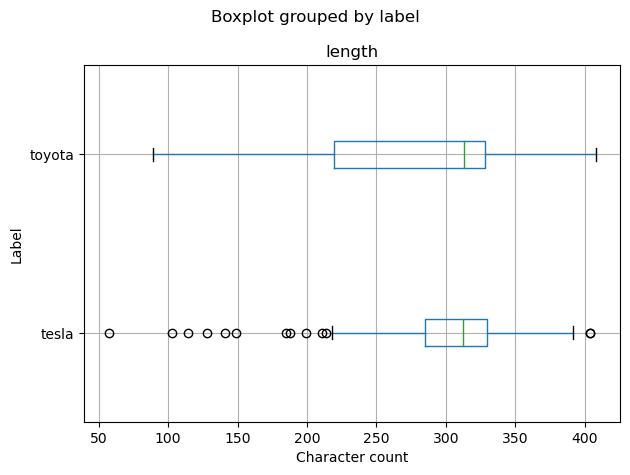

In [64]:
# crete boxplot to see distribution of counts by label
plt.figure(figsize=(8, 6))
combined.boxplot(column='length', by='label', vert=False)
plt.xlabel('Character count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

### clean and process text

In [65]:
# define function to tokenize text
def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [66]:
# check stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
list(stopwords)[:5]

["should've", 'mightn', "needn't", 'doing', 'through']

In [67]:
# add tesla and toyota as stopwords, we do not want to see these words in the features
include_stopwords = {'tesla', 'toyota'}
stopwords |= include_stopwords

In [68]:
# define function to remove stopwords
def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

In [69]:
# create pipeline to lowercase, tokenize and remove stop words
pipeline = [str.lower, tokenize, remove_stop]

# define function to feed text data through the pipeline and return cleaned tokens
def prepare(text, pipeline):

  # convert text to string if it's not already a string (for float types)
  text = str(text)

  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens

In [70]:
combined['tokens'] = combined['text'].apply(prepare, pipeline=pipeline)
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"[full, self, driving, could, come, countries, ..."
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla,More Than 3× As Many Tesla Model Y Sales As Te...,346.0,"[many, model, sales, model, sales, usa, 1st, q..."
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla Surprises Investors With A Tiny Y & A Ti...,333.0,"[surprises, investors, tiny, tiny, soon, year,..."
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla,The Revisionist Language That Tesla Used In Th...,330.0,"[revisionist, language, used, q1, earnings, ca..."
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla,French startup FlexAI exits stealth with $30M ...,232.0,"[french, startup, flexai, exits, stealth, 30m,..."


In [71]:
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"[full, self, driving, could, come, countries, ..."


In [72]:
# get the number of tokens as a field
combined['num_tokens'] = combined['tokens'].map(len)
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"[full, self, driving, could, come, countries, ...",32


### EDA and visualizations

In [82]:
# seperate records based on labels in 2 different series
tesla_tokens = combined.loc[combined['label'] == 'tesla', 'tokens']
toyota_tokens = combined.loc[combined['label'] == 'toyota', 'tokens']

tesla_tokens[:5]

0    [full, self, driving, could, come, countries, ...
1    [many, model, sales, model, sales, usa, 1st, q...
2    [surprises, investors, tiny, tiny, soon, year,...
3    [revisionist, language, used, q1, earnings, ca...
4    [french, startup, flexai, exits, stealth, 30m,...
Name: tokens, dtype: object

In [81]:
# flatten each so we can get all tokens in each df into a single list
tesla_flat_tokens = [word for sublist in tesla_tokens for word in sublist]
toyota_flat_tokens = [word for sublist in toyota_tokens for word in sublist]

tesla_flat_tokens[:5]

['full', 'self', 'driving', 'could', 'come']

In [83]:
# 2828 tokens
len(tesla_flat_tokens)

2828

In [87]:
# get count of each word 
tesla_word_counts = Counter(tesla_flat_tokens)
toyota_word_counts = Counter(toyota_flat_tokens)

# check the first 5 records
dict(list(tesla_word_counts.items())[:5])

{'full': 10, 'self': 3, 'driving': 3, 'could': 7, 'come': 3}

In [92]:
# get the 10 most common words for both each
print(tesla_word_counts.most_common(10))

[('musk', 34), ('elon', 29), ('ev', 24), ('model', 22), ('earnings', 21), ('company', 20), ('china', 19), ('electric', 18), ('cybertruck', 18), ('fsd', 16)]


In [93]:
print(toyota_word_counts.most_common(10))

[('motor', 45), ('electric', 28), ('ev', 25), ('new', 22), ('sales', 21), ('com', 21), ('billion', 21), ('year', 19), ('america', 18), ('marketscreener', 18)]


In [107]:
# convert counter type to list so we can plot
top_tesla_words = list(tesla_word_counts.most_common(10))
top_toyota_words = list(toyota_word_counts.most_common(10))

In [109]:
# get words and their count from the list
tesla_words, tesla_counts = zip(*top_tesla_words)
toyota_words, toyota_counts = zip(*top_toyota_words)

print(tesla_words)
print(tesla_counts)

('musk', 'elon', 'ev', 'model', 'earnings', 'company', 'china', 'electric', 'cybertruck', 'fsd')
(34, 29, 24, 22, 21, 20, 19, 18, 18, 16)


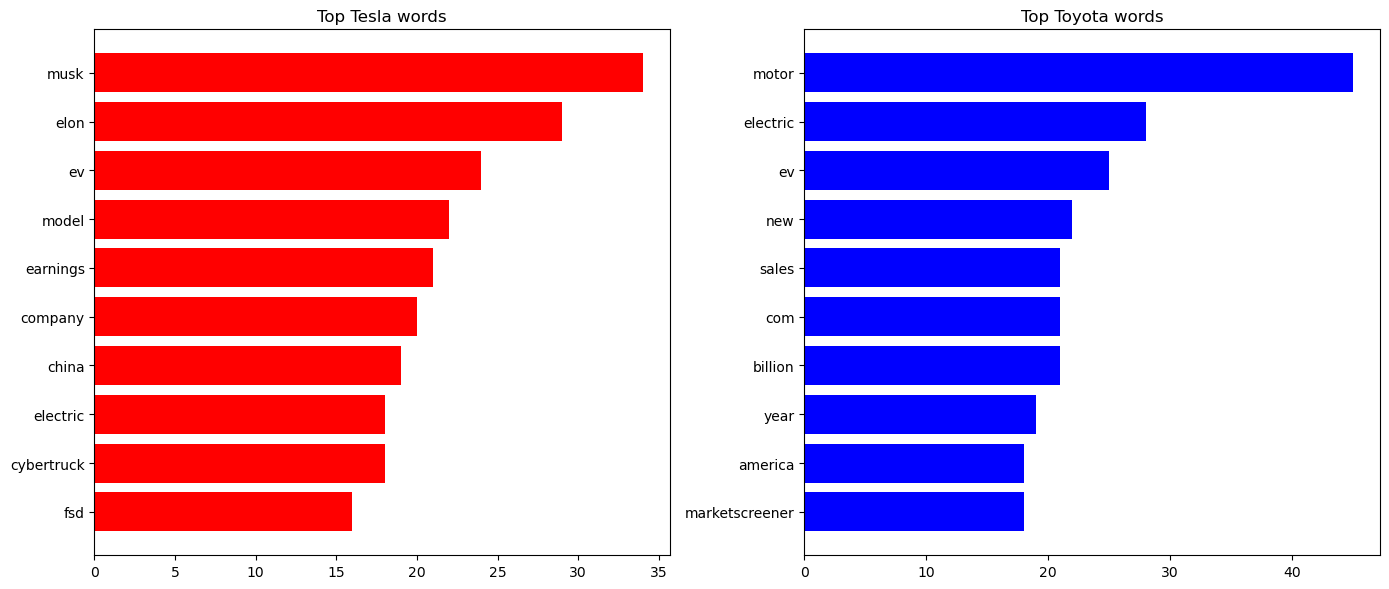

In [111]:
# create 2 subplots, next to eachother
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# plot tesla words, highest counts at the top
ax[0].barh(tesla_words, tesla_counts, color='red')
ax[0].invert_yaxis()
ax[0].set_title('Top Tesla words')

# do the same for toyota
ax[1].barh(toyota_words, toyota_counts, color='blue')
ax[1].invert_yaxis()  # Highest counts at the top
ax[1].set_title('Top Toyota words')

# show the plot, tight layout so fit is better
plt.tight_layout()
plt.show()

In [113]:
# now to get the descriptive statistics, define the function created in earlier assignments
def descriptive_stats(tokens, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # length of num tokens list
    num_tokens = len(tokens)

    # length of unique tokens in list
    num_unique_tokens = len(set(tokens))

    # unique tokens divided by total tokens to see diversity
    lexical_diversity = num_unique_tokens / num_tokens

    # get sum of characters
    sum = 0
    for word in tokens:
        for char in word:
            sum += 1

    num_characters = sum
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [116]:
# Split the DataFrame based on the "label" field
tesla_df = combined[combined['label'] == 'tesla']
toyota_df = combined[combined['label'] == 'toyota']

# Combine all the lists in the "tokens" field into one giant list for each DataFrame
tesla_tokens = [item for sublist in tesla_df['tokens'] for item in sublist]
toyota_tokens = [item for sublist in toyota_df['tokens'] for item in sublist]

In [118]:
tesla_tokens[:5]

['full', 'self', 'driving', 'could', 'come']

In [119]:
# apply descriptive stats to the tesla tokens
descriptive_stats(tesla_tokens)

There are 2828 tokens in the data.
There are 1424 unique tokens in the data.
There are 17430 characters in the data.
The lexical diversity is 0.504 in the data.


[2828, 1424, 0.5035360678925035, 17430]

In [120]:
# do the same for toyota
descriptive_stats(toyota_tokens)

There are 2763 tokens in the data.
There are 1248 unique tokens in the data.
There are 17610 characters in the data.
The lexical diversity is 0.452 in the data.


[2763, 1248, 0.4516829533116178, 17610]

## Part 2: Classification Models

In [121]:
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"[full, self, driving, could, come, countries, ...",32
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla,More Than 3× As Many Tesla Model Y Sales As Te...,346.0,"[many, model, sales, model, sales, usa, 1st, q...",31
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla Surprises Investors With A Tiny Y & A Ti...,333.0,"[surprises, investors, tiny, tiny, soon, year,...",29
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla,The Revisionist Language That Tesla Used In Th...,330.0,"[revisionist, language, used, q1, earnings, ca...",30
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla,French startup FlexAI exits stealth with $30M ...,232.0,"[french, startup, flexai, exits, stealth, 30m,...",25
